# Present Value of Liabilities and Funding Ratio

In this lab session, we'll examine how to discount future liabilities to compute the present value of future liabilities, and measure the funding ratio.

The funding ratio is the ratio of the current value of assets to the present value of the liabilities.

In order to compute the present value, we need to discount the amount of the liability based on the relevant interest rate derived from the yield curve.

For simplicity, we'll assume that the yield curve is flat, and so the interest rate is the same for all horizons.

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def discount(r , t):
    return (1 / (1+r)**t)

In [5]:
discount(0.03 , 10)

0.7440939148967249

That means if you invest 0.74 in bonds(safe investment) u will make 1 dollar after 10 years

In [6]:
def pv(l , r):
    tt = l.index
    discounts = discount(r , tt)
    return (l * discounts).sum()

In [7]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

In [8]:
pv(liabilities , 0.03)

6.233320315080044

We can now compute the funding ratio, based on current asset values:

In [9]:
def funding_ratio(asset , liabliities , r):
    return asset / pv(liabilities , r)

In [10]:
funding_ratio(5 , liabilities , 0.03)

0.8021407126958778

In [11]:
import ipywidgets as widgets
from IPython.display import display

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print('Funding Ratio' , fr*100)
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# Simulating Interest Rate Changes and Liability Hedging
### Implementing the Cox Ingersoll Ross Model for interest rates

We saw in the previous lab that when you look at your financial condition in terms of funding ratio, rather than asset value, even cash can be a risky asset.

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. It is very similar to what we have already done for generating random stock prices. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

### Short Rate vs Annualized Rate

One final piece of math we'll need is that the interest rate being described here is the "instantaneous" or "short rate" ... we will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

### Quick Explanation of Short Rate vs Annual Rate

The distinction between the instantaneous rate and the annualized rate is subtle if you have never had an opportunity to think about it, but is best understood in terms of an example:

Let's consider the growth of a dollar over a year, if the rate of interest is 100%.

To answer the question about what that will grow to at the end of the year, we'll need to answer a second question, which is how often will that interest be paid?

If it's paid just once at the end of the year, the answer is easy. The dollar grows to 2 dollars (one dollar in principle and another dollar in interest).

In [12]:
def inst_to_ann(r):
    return (np.exp(r)-1)

def ann_to_inst(r):
    return np.log(1+r)

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

In [14]:
cir().head()

,0
0,0.030000
1,0.029953
2,0.031788
3,0.031443
4,0.027870


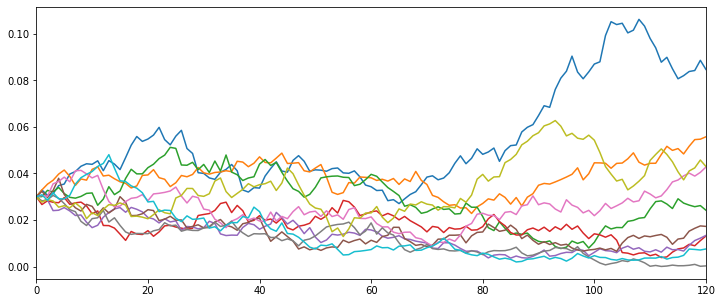

In [19]:
cir(n_scenarios=10).plot(legend=False, figsize=(12,5))

In [20]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))

import ipywidgets as widgets
from IPython.display import display
    
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [21]:
import math
def cir1(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):

    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        P = A*np.exp(-B*r)
        return P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [22]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir1(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [18]:
cir1(n_years = 10, n_scenarios=3, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None)

(            0         1         2
 0    0.030000  0.030000  0.030000
 1    0.031262  0.030252  0.029367
 2    0.030074  0.032019  0.028656
 3    0.029720  0.034279  0.029255
 4    0.031769  0.030518  0.030246
 ..        ...       ...       ...
 116  0.000987  0.026390  0.012120
 117  0.001155  0.028182  0.012840
 118  0.001500  0.027491  0.010072
 119  0.002477  0.025493  0.010717
 120  0.003281  0.027157  0.011935
 
 [121 rows x 3 columns],             0         1         2
 0    0.747073  0.747073  0.747073
 1    0.741679  0.747381  0.752410
 2    0.750132  0.739219  0.758184
 3    0.753872  0.728577  0.756501
 4    0.744189  0.751147  0.752669
 ..        ...       ...       ...
 116  0.999591  0.991232  0.995919
 117  0.999667  0.992977  0.996769
 118  0.999730  0.995427  0.998309
 119  0.999789  0.997877  0.999104
 120  1.000000  1.000000  1.000000
 
 [121 rows x 3 columns])

In [1]:
import math
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):

    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows

In [4]:
bond_cash_flows(3, 1000, .06, 2)

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [5]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):

    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

In [19]:
bond_price(3, 1000, 0.06, 2, .04)

1056.0143089069038

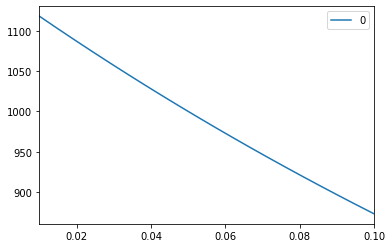

In [18]:
dis = np.linspace(0.01 , 0.1 , 20)
a = [bond_price(3 , 1000 , 0.05 , 2 , rate) for rate in dis]
a = pd.DataFrame(a , dis)
a.plot()

As intrest rate increases bond prices decreases.